# Introduction to Low-Rank Approximation

---

> Author: <font color='#f78c40'>Samuel Farrens</font>    
> Year: 2017  
> Email: [samuel.farrens@gmail.com](mailto:samuel.farrens@gmail.com)  
> Website: <a href="https://sfarrens.github.io" target="_blank">https://sfarrens.github.io</a>

---


## Contents

---
 
1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
1. [Rank of a Matrix](#Rank-of-a-Matrix)
 * [Full Rank Matrix](#Full-Rank-Matrix) 
 * [Reduced Rank Matrix](#Reduced-Rank-Matrix) 
 * [Uneven Matrix](#Uneven-Matrix)
1. [Singular Value Decomposition](#Singular-Value-Decomposition) 
 * [Reducing the Rank](#Reducing-the-Rank)
 * [Hard Thresholding](#Hard-Thresholding)
1. [Low Rank Approximation](#Low-Rank-Approximation)
 * [Nuclear Norm](#Nuclear-Norm)
1. [Deconvolution Exercise](#Deconvolution-Exercise)
 * [Gradient](#Gradient)
 * [Rank Reduction](#Rank-Reduction)
 * [Optimisation](#Optimisation)
 * [Deconvolution](#Deconvolution)
1. [Hints](#Hints)
1. [Exercise Solutions](#Exercise-Solutions)
 * [Deconvolution Exercise Solution](#Deconvolution-Exercise-Solution)

---

## Set-Up

Here we will import a couple of packages that we will need throughout the notebook.

In [1]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np        

# Import the FFT convolution function from Scipy.
from scipy.signal import fftconvolve

# Import the Gaussian kernel function from Astropy.
from astropy.convolution import Gaussian2DKernel

# Import the pyplot package from matplotlib with the alias plt.
import matplotlib.pyplot as plt  
from matplotlib import pylab

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

---

## Introduction

The knowledge that a given matrix contains a certain amount of redundancy can be used a powerful prior for solving inverse problems. The notebook provides a brief introduction to the concepts of matrix rank and the low-rank approximation for regularisation. This notebook does not provide a comprehensive review on these topics, rather it is intended to give the user some intuitive hands-on experience.

---

## Rank of a Matrix

The rank of a matrix can be defined in the following ways:

1. the maximum number of linearly independent column vectors in a given matrix
1. the maximum number of linearly independent row vectors in a given matrix

Both of these definitions are equivalent.

### <font color='blue'>Full Rank Matrix</font>

For the matrix

$$ A = \begin{bmatrix} 6 & 1 & 2 \\ 5 & 6 & 1 \\ 5 & 7 & 7 \end{bmatrix} $$

the rank is given by

$$\textrm{rank}(A) = 3$$

since all three rows are linearly idependent. $A$ is then said to have **full rank**.

This can be implemented in Python as follows

In [2]:
A = np.array([[6, 1, 2], [5, 6, 1], [5, 7, 7]])

print 'A ='
print A
print ''
print 'rank(A) =', np.linalg.matrix_rank(A)

A =
[[6 1 2]
 [5 6 1]
 [5 7 7]]

rank(A) = 3


### <font color='blue'>Reduced Rank Matrix</font>

For the matrix

$$ A = \begin{bmatrix} 1 & 0 & 1 \\ -2 & -3 & 1 \\ 3 & 3 & 0 \end{bmatrix} $$

the rank is given by

$$\textrm{rank}(A) = 2$$

since the third row is simply the difference of the first two, which are linearly idependent. In this case $A$ is **rank deficient** or has **reduced rank**.

In [3]:
A = np.array([[1, 0, 1], [-2, -3, 1], [3, 3, 0]])

print 'A ='
print A
print ''
print 'rank(A) =', np.linalg.matrix_rank(A)

A =
[[ 1  0  1]
 [-2 -3  1]
 [ 3  3  0]]

rank(A) = 2


### <font color='blue'>Uneven Matrix</font>

For a matrix $\in\mathbb{R}^{m\times n}$, if $m>n$ then the maximum rank of the matrix is $n$ (*i.e.* if the matrix has more rows than columns then the maximum value of the rank is the number of columns). Conversely, if $m<n$ then the maximum rank is $m$.

For example, we can calculate the rank of a $5\times 3$ matrix $A$ and a $3\times 2$ matrix $B$ both of which have linearly independent columns as follows

In [4]:
np.random.seed(1)
A = np.random.randint(-9, 9, (5, 3))
B = np.random.randint(-9, 9, (3, 2))

print 'A ='
print A
print ''
print 'rank(A) =', np.linalg.matrix_rank(A)
print ''
print 'B ='
print B
print ''
print 'rank(B) =', np.linalg.matrix_rank(B)

A =
[[-4  2  3]
 [-1  0  2]
 [-4  6 -9]
 [ 7 -8  3]
 [-2  4 -3]]

rank(A) = 3

B =
[[-4  2]
 [ 1  5]
 [-5  0]]

rank(B) = 2


## Singular Value Decomposition

The rank of a matrix can also be measured by counting the number of non-zero singular values.

The <a href="https://en.wikipedia.org/wiki/Singular_value_decomposition" target="_blank">SVD</a> of a matrix $A$ is given by

$$A = U\Sigma V^T$$

where $\Sigma$ are the singular values. Thus, the rank of $A$ is

$$\textrm{rank}(A) = \|\Sigma\|_0$$

In [5]:
# Define the matrix A
A = np.array([[1, 0, 1], [-2, -3, 1], [3, 3, 0]])

# Calculate the SVD of A
U, S, V = np.linalg.svd(A)

# Round the values of S to two decimal places. Comment out this operation to see why this is done.
S = np.around(S, 2)

print 'A ='
print A
print ''
print 'Sigma ='
print np.diag(S)
print ''
print 'rank(A) =', sum(S > 0)
print '(or rank(A) =', np.linalg.norm(S, 0), ')'

A =
[[ 1  0  1]
 [-2 -3  1]
 [ 3  3  0]]

Sigma =
[[ 5.61  0.    0.  ]
 [ 0.    1.61  0.  ]
 [ 0.    0.    0.  ]]

rank(A) = 2
(or rank(A) = 2.0 )


### <font color='blue'>Reducing the Rank</font>

By definition setting one or more singular values to zero reduces the rank of a given matrix.

For example, for a matrix with rank 2

In [6]:
# Define the matrix A
A = np.array([[7, 3, -4], [-5, 1, 2], [2, 4, -2]])

# Calculate the SVD of A
U, S, V = np.linalg.svd(A)
S = np.around(S, 2)

print 'A ='
print A
print ''
print 'Sigma ='
print np.diag(S)
print ''
print 'rank(A) =', np.linalg.matrix_rank(A) 

A =
[[ 7  3 -4]
 [-5  1  2]
 [ 2  4 -2]]

Sigma =
[[ 10.55   0.     0.  ]
 [  0.     4.09   0.  ]
 [  0.     0.     0.  ]]

rank(A) = 2


the rank is reduced to 1 when the second singular value is set to zero.

In [7]:
#Set the second singular value to 0
S[1] = 0

# Create a new matrix with the updated singular values
B = np.dot(U, np.dot(np.diag(S), V))

print 'Sigma ='
print np.diag(S)
print ''
print 'B ='
print B
print ''
print 'rank(B) =', np.linalg.matrix_rank(B)

Sigma =
[[ 10.55   0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]]

B =
[[ 7.0744821   2.8325134  -3.98817734]
 [-3.87488447 -1.55144391  2.18443219]
 [ 3.19959763  1.28106949 -1.80374515]]

rank(B) = 1


### <font color='blue'>Hard Thresholding</font>

Another way of looking at this would be apply a **Hard Threshold** to the singular values of the matrix.

$$ 
HT_{\lambda}(\mathbf{x}) = 
\begin{cases} 
\mathbf{x} & \text{if}\ |\mathbf{x}| \geq \lambda \\ 
0 & \text{otherwise} \\
\end{cases}
$$

In [8]:
def hard_thresh(value, threshold):
    '''Hard Threshold
    
    Returns hard threshold of input
    
    '''
    
    return value * (np.abs(value) >= threshold)

For example, for a full rank matrix $A$ ($\textrm{rank}(A)=3$)

In [9]:
# Define a matrix of random values with seed 1
np.random.seed(1)
A = np.random.randint(-9, 9, (3, 3))

# Calculate the SVD of A
U, S, V = np.linalg.svd(A)
S = np.around(S, 2)

print 'A ='
print A
print ''
print 'Sigma ='
print np.diag(S)
print ''
print 'rank(A) =', np.linalg.matrix_rank(A) 

A =
[[-4  2  3]
 [-1  0  2]
 [-4  6 -9]]

Sigma =
[[ 11.6    0.     0.  ]
 [  0.     5.7    0.  ]
 [  0.     0.     0.06]]

rank(A) = 3


a new matrix $B$ with a rank of 1 can be obtained by applying a hard threshold with $\lambda=6$ to the singular values of $A$.

In [10]:
# Hard threshold values of sigma
S_ht = hard_thresh(S, 6)

# Create a new matrix with the updated singular values
B = np.dot(U, np.dot(np.diag(S_ht), V))

print 'HT(Sigma) ='
print np.diag(S_ht)
print ''
print 'B ='
print B
print ''
print 'rank(B) =', np.linalg.matrix_rank(B)

HT(Sigma) =
[[ 11.6   0.    0. ]
 [  0.    0.    0. ]
 [  0.    0.    0. ]]

B =
[[  2.97190857e-03  -4.58421109e-03   7.04517481e-03]
 [  4.15802665e-01  -6.41381504e-01   9.85697370e-01]
 [ -3.84445041e+00   5.93011925e+00  -9.11361321e+00]]

rank(B) = 1


Therefore, with an appropriate threshold, one can reduce the rank of a given matrix.

---

## Low Rank Approximation

The <a href="https://en.wikipedia.org/wiki/Low-rank_approximation" target="_blank">low-rank approximation</a> is a minimisation constraint that is subject to the condition that the matrix one wishes to obtain has reduced rank. In other words, we can use the prior knowledge that the matrix one wants to recover is of reduced rank when solving an inverse problem.

### <font color='blue'>Nuclear Norm</font>

As with the $l_0$ norm in sparse regularisation, the rank of the matrix cannot be used directly for regularisation as it is a non-convex function. Instead the nuclear norm (or trace norm) is used to promote low-rank solutions. The nuclear norm is given by the sum of singular values,

$$\|X\|_* = \sum_{k=1} \sigma_k(X)$$

where $\sigma_k(X)$ denotes the $k^{\textrm{th}}$ largest singular value of $X$. This can be implemented in Python as follows

In [11]:
def nuclear_norm(data):
    '''Nuclear Norm
    
    This function returns the nuclear norm of the input data.
    
    '''

    # Get SVD of the data.
    u, s, v = np.linalg.svd(data)

    # Return nuclear norm.
    return np.sum(s)

For example, given a full rank matrix $A$ and a rank 2 matrix $B$ one can see that the nuclear norm of $B$ is smaller than that of $A$.

In [12]:
A = np.array([[6, 1, 2], [5, 6, 1], [5, 7, 7]])
B = np.array([[1, 0, 1], [-2, -3, 1], [3, 3, 0]])

print 'rank(A)=', np.linalg.matrix_rank(A)
print '||A||*=', nuclear_norm(A)
print ''
print 'rank(B)=', np.linalg.matrix_rank(B)
print '||B||*=', nuclear_norm(B)

rank(A)= 3
||A||*= 21.4800513015

rank(B)= 2
||B||*= 7.21110255093


---

## <font color='red'>Deconvolution Exercise</font>


For this exercise you will revist the concept of deconvolution (prevuiously discussed in the <a href="./inverse_problems.ipynb" target="_blank">Inverse Problems notebook</a>).

We begin by defining a matrix $X$ with rank 1.

rank(X)= 1


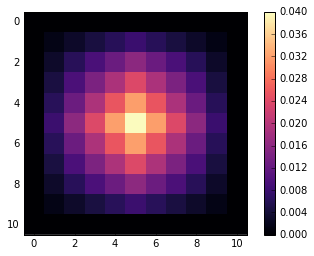

In [13]:
#############################
# NO NEED TO EDIT THIS CELL #
# JUST EXECUTE IT           #
#############################

# Define a 11x11 matrix X
vals = np.array(range(6) + range(5)[::-1]) 
X = np.array([i * vals for i in range(6)] + [i * vals for i in range(5)[::-1]], dtype='float')
X /= X.sum()

# Calculate the rank of X
print 'rank(X)=', np.linalg.matrix_rank(X)

# Display X
plt.imshow(X, interpolation='none', cmap='magma')
plt.colorbar()
plt.show()

A slightly blurred version of $X$ with noise is given by

$$Y = MX + N$$

where $M$ represents the convolution of $X$ with a blurring kernel and $N$ is additive Gaussian noise.

rank(Y)= 11


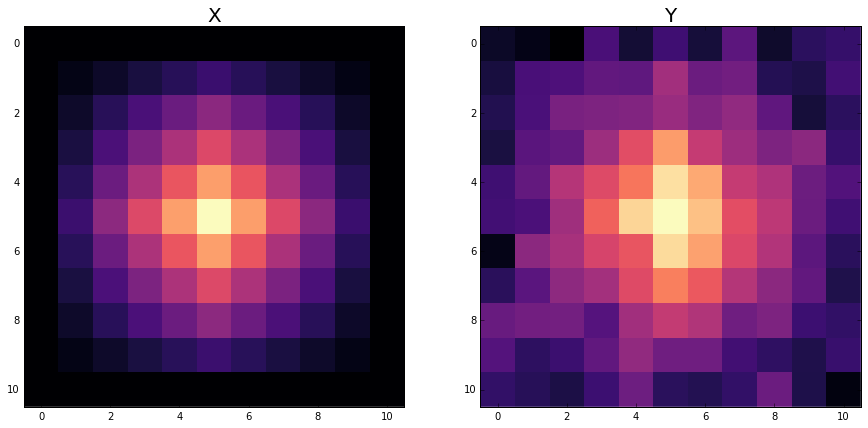

In [14]:
#############################
# NO NEED TO EDIT THIS CELL #
# JUST EXECUTE IT           #
#############################

def blur(data, kernel):
    '''Blurring operator

    This function convolves the input data with the blurring kernel.

    '''
    
    return fftconvolve(data, kernel, 'same')

def blur_transpose(data, kernel):
    '''Adjoint blurring operator
    
    This function convolves the input data with the rotated blurring kernel.
    
    '''
    
    return fftconvolve(data, np.rot90(kernel, 2), 'same')

# Define a 3x3 Gaussian kernel
gauss_kernel = np.array(Gaussian2DKernel(0.5, x_size=3, y_size=3))

# Blur X and add noise
Y = blur(X, gauss_kernel) + 0.003 * np.random.randn(*X.shape)

# Calculate the rank of Y
print 'rank(Y)=', np.linalg.matrix_rank(Y)

# Display X and Y
plt.figure(figsize=(15, 12))
plt.subplot(121)
plt.imshow(X, interpolation='none', cmap='magma')
plt.title('X', fontsize=20)
plt.subplot(122)
plt.imshow(Y, interpolation='none', cmap='magma')
plt.title('Y', fontsize=20)
plt.show()

$Y$ is clearly distorted with respect to $X$. This sort of distortion is present in virtually all images obtained with optical instruments (*e.g.* telescopes, microscopes, *etc.*).

In order to recover $X$ we will aim to solve the problem using the following minimsation:

$$\begin{aligned} & \underset{X}{\text{argmin}} & \frac{1}{2}\|Y-MX\|_2^2 + \lambda\|X\|_*\end{aligned}$$

which imposes a low-rank solution of $X$ via the nuclear norm term.

### <font color='red'>Gradient</font>

Your first task is to define a function that calculates the gradient of the minimisation problem, which is given by

$$\nabla F(X) = M^T(MX-Y)$$

> See the [Hints](#Hints) if you get stuck.

<br />
<font color='red'>EDIT THE CELL BELOW</font>

In [15]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

def grad(y, x_rec, kernel):
    '''Gradient
    
    This function calculates the gradient given the observation and an approximation of the true signal.
    
    '''

    return None

### <font color='red'>Rank Reduction</font>

Your next task is to define a function for imposing that the recovered matrix has a reduced rank.

To complete this task you will need to:
1. calculate some measure of the rank of the input data
1. reduce the this rank using the input threshold
1. return the updated matrix

> See the [Hints](#Hints) if you get stuck.

<br />
<font color='red'>EDIT THE CELL BELOW</font>

In [16]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

def reduce_rank(x, threshold):
    '''Reduce Rank
    
    This function reduces the rank of the input value x using the specified threshold.
    
    '''
    
    return None

###  <font color='blue'>Optimisation</font>

For this exercise we will use the forward-backward splitting algorithm with a rank reduction operation to promote low-rank solutions. It has the following form for each iteration:

$$X_{n+1} = X_n - \gamma * \nabla F(X_n)$$
$$X_{n+1} = \text{RR}_\lambda(X_{n+1})$$

In [17]:
#############################
# NO NEED TO EDIT THIS CELL #
# JUST EXECUTE IT           #
#############################

def cost_func(y, x_rec, threshold, kernel):
    '''Cost Function
    
    Return the cost of the given estimate of x
    
    '''
    
    return 0.5 * np.linalg.norm(y - blur(x_rec, kernel)) ** 2 + threshold * nuclear_norm(x_rec)

def forwardBackward(observation, first_guess, threshold, kernel):
    '''Forward-Backward Algorithm
    
    Return the recovered signal using a rank reduction operator
    
    '''
            
    x_rec = first_guess
    
    n_iter = 15
    gamma = 1.0
        
    for i in range(n_iter):
        
        x_temp = x_rec - gamma * grad(observation, x_rec, kernel)
        x_rec = reduce_rank(x_temp, threshold)
        cost = cost_func(observation, x_rec, threshold, kernel)
        print 'Iteration', i + 1, 'Cost =', cost
        
    return x_rec

### <font color='red'>Deconvolution</font>

Your final task is to perform the deconvolution.

1. Set the low-rank threshold value ($\lambda$).
1. Set an initial value for $X$.
1. Implement the forward-backward algorithm with the following inputs:
 1. The blurred noisy matrix.
 1. The initial value for $X$.
 1. The threshold.
 1. The blurring kernel.

> See the [Hints](#Hints) if you get stuck.

<br />
<font color='red'>EDIT THE CELL BELOW</font>

In [18]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Set the threshold value.
threshold = None

# Set initial guess for X.
first_guess = None

# Recover the matrix.
X_rec = None

# Calculate the rank of recoverd matrix.
rank_x_rec = None

if not isinstance(rank_x_rec, type(None)):
    print ''
    print 'rank(X_rec)=', rank_x_rec

In [19]:
#############################
# NO NEED TO EDIT THIS CELL #
# JUST EXECUTE IT           #
#############################

# Display
if not isinstance(X_rec, type(None)):
    plt.figure(figsize=(17, 12))
    plt.subplot(131)
    plt.imshow(X, interpolation='none', cmap='magma')
    plt.title('$X$', fontsize=20)
    plt.subplot(132)
    plt.imshow(Y, interpolation='none', cmap='magma')
    plt.title('$Y$', fontsize=20)
    plt.subplot(133)
    plt.imshow(X_rec, interpolation='none', cmap='magma')
    plt.title('$\hat{X}$', fontsize=20)
    plt.show()

Does your final $\hat{X}$ look more like $X$ or $Y$? Try ajusting $\lambda$ to see if that improves your results.

---

## <font color='orange'>Hints</font>

** Gradient **

1. The blurring operators are already defined.

** Rank Reduction **

1. Make sure you are thresholding something *singular*.
1. Thresholding matrices can be quite *hard*.

** Deconvolution **

1. Make sure your first guess of $X$ is the right shape.
1. Try adjusting your value of $lambda$

---

## Exercise Solutions

**<font color="red">Warning!</font>** Try your best to solve all of the exercises on your own before checking the answers.

<br />

### Deconvolution Exercise Solution

** Gradient **

```Python

def grad(y, x_rec, kernel):
    '''Gradient
    
    This function calculates the gradient given the observation and an approximation of the true signal.
    
    '''

    return blur_transpose(blur(x_rec, kernel) - y, kernel)
    
```

** Rank Reduction **

```Python

def reduce_rank(x, threshold):
    '''Reduce Rank
    
    This function reduces the rank of the input value x using the specified threshold.
    
    '''
    
    u, s, v = np.linalg.svd(x)
        
    s_new = hard_thresh(s, threshold)
    
    return np.dot(u, np.dot(np.diag(s_new), v))

```

** Deconvolution **

```Python

# Set the threshold value.
threshold = 0.1

# Set initial guess for X.
first_guess = np.ones(Y.shape)

# Recover the matrix.
X_rec = forwardBackward(Y, first_guess, threshold, gauss_kernel)

# Calculate the rank of recoverd matrix.
rank_x_rec = np.linalg.matrix_rank(X_rec)

```